# 確率的潜在意味スケーリング (PLSS)
LSS を項目反応理論 (IRT) をもとに統計モデルとして確率化したテキストの潜在的な尺度に対応する連続値を扱うことのできるモデル

確率的潜在意味スケーリング (Probabilistic Latent Semantic Scaling)  
http://chasen.org/~daiti-m/paper/nl249plss.pdf

## 項目反応理論 (IRT)
心理統計学の分野で開発された方法論で、テストの結果から被験者の潜在的な能力あるいは傾向 $\theta$ を推定することを目的とする。被験者の $\theta$ は標準正規分布 $\mathcal{N}(0,1)$ に従っていると仮定する。
$$
\theta \sim \mathcal{N}(0, 1) \tag{4}
$$

被験者 $i$ の問題 $j$ 対する正答確率 $p_{ij}$ は次のようにモデル化される。
$$
p_{ij} = \sigma(\alpha_j(\theta_i-\beta_j)) \tag{5}
$$

$\sigma(x)=\frac{1}{1+e^{-x}}$ は、ロジスティック（シグモイド）関数。問 $j$ への正答率は問題の難易度を表す $\beta_j$ を境に、$\alpha_j$ に比例する確率で上昇することを表している。

観測データとして$Y = \{y_{ij}\}_{i,j}$ を考え、$y_{ij}$ は被験者$i$が問 $j$ に正答した時 1, 誤ったときに 0 とすると、$Y$ の確率は下記のようにあらわすことができる。
$$
\begin{align}
p(Y|\alpha, \beta, \theta) &= \prod_i\prod_j Bernoulli (y_{ij}|p_{iij}) \tag{6} \\
&= \prod_i\prod_j Bernoulli (y_{ij}|\sigma(\alpha_j(\theta_i-\beta_j))) \tag{7}
\end{align}
$$

IRT では事前確率 (4) の下で尤度 (7) を最大にするパラメータ ${\alpha_i, \beta_j}$ を求め、同時に被験者の能力 ${\theta_i}$ を推定する。

## PLSS の生成過程
PLSS ではまず式 (5) を多項分布に拡張する形で、テキストにおける単語 $v$ の確率を次のようにモデル化する。
$$
\begin{align}
p(v|\theta,\phi) &\propto p(v)exp(\theta \cdot \phi_v) \tag{8} \\
&= \frac{exp(\log p(v) + \theta \cdot \phi_v)}{\sum^V_{v=1}exp(\log p(v)+\theta \cdot \phi_v)} \tag{9}
\end{align}
$$
Wordfish 同様に $\phi_v \in \mathbb{R}$ は、単語 $v$ の潜在的な極性、$\theta \sim \mathcal{N}(0, 1)$ は、テキストの潜在的な極性を表す。  
このモデルは、IRT の多項分布化、あるいは式 (9) で表される多項ロジスティック回帰において、$\theta$ も $\phi$ も未知の場合の教師なし学習とみなすことができる。

このとき、テキスト $d$ の確率は単語 $v$ のテキスト内での頻度を $n_{dv}$ とおくと
$$
p(d|\theta,\phi) = \prod^V_{v=1} p(v|\theta,\phi)^{n_{dv}} \tag{10}
$$
と書けるので、$D$ 個のテキストからなるコーパス $D$ 全体の確率は、
$$
p(D|\Theta,\phi) = \prod^{D}_{d=1}\prod^{V}_{v=1} p(v|\theta_d,\phi)^{n_{dv}} \tag{11}
$$
と表せる。

式 (11) は、mcmc や最適化でパラメータを推定することが可能だが、$\phi_1,\cdots,\phi_V$ を独立に学習するため、単語間の意味的関係を扱えないという問題がある。
PLSS では、単語極性 $\phi$ をニューラル単語ベクトルを用いて設計する事でこれに対処している。

## 単語極性の設計
PLSS では、を $K$ 次元のニューラル単語ベクトル $\vec{v}$ を用いて、$\phi_v$ を下記の通り計算する。
$$
\phi_v = \boldsymbol{\beta}^T\vec{v}
$$
これにより、各単語の $\phi$ を独立に推定する代わりに $K$ 次元の係数ベクトル $\boldsymbol{\beta}$ を１つ推定するだけでよくなる。 
この $\boldsymbol{\beta}$ は、単語埋め込みベクトル空間における"良い-悪い", "右翼-左翼"のような $\theta$ の極性を与える「意味方向（極性軸）」を表している。  

これによって、式 (9) は、
$$
\begin{align}
p(v|\theta,\boldsymbol{\beta}) &= \frac{exp(\log p(v) + \theta \cdot \boldsymbol{\beta}^T\vec{v})}{\sum^V_{v=1}exp(\log p(v)+\theta \cdot \boldsymbol{\beta}^T\vec{v})} \tag{12}
\end{align}
$$
と表すことができる。  

$\theta$ と $\boldsymbol{\beta}$ を式 (11) に基づいて、教師なしで同時推定することも可能だが、これによって学習される $\boldsymbol{\beta}$ は、Wordfish 同様に分析の目的に一致しているとは限らないとして、より直接的に単語極性の設計している。  

論文では、分析目的の対応した正と負の極性単語集合が与えられた時に、意味方向 $\boldsymbol{\beta}$  を計算する方法として、以下の二つをあげている。

- 超密埋め込み (Ularadense embedding) [DensRay](https://arxiv.org/abs/1904.08654) 
- 単純に負の極性語の平均ベクトルから正の極性語の平均ベクトルへの方向ベクトルを用いる方法

### DensRay による意味方向の設計
＃ ここわかってない

語彙集合 $V := \{v_1, v_2, ..., v_n\}$ とその埋め込み $E \in \mathbb{R}^{n \times d}$ および、言語的特徴アノテーション $l:V \to \{-1,1\}$ が与えられた時に、$EQ$ が解釈可能となるような、直交行列 $Q \in \mathbb{R}^{d \times d}$ を求めることを目的とする。   
これによって求まった、$EQ$ の最初の $k$ 次元を解釈可能な超高密度の単語空間 (interpretable ultradense word space) と呼ぶ。  

DensRay では、言語的信号 $L_=:= \{(v, w) \in V \times V |\; l(v) = l(w)\}$ および $L_{\not =}:= \{(v, w) \in V \times V |\; l(v) {\not =} l(w)\}$ が与えられた上で、[Densifier](https://arxiv.org/abs/1602.07572) を修正した、以下の目的関数について最適化する。

$$
\begin{align}
\max_q \sum _ {(v,w) \in L_{\not =}} \alpha_{\not =} &\left\| q^\intercal d_{vw} \right\| _ { 2 }^2- \nonumber \\
&\sum _ { (v,w) \in L_{=}}  \alpha_{=}  \left\| q^\intercal d_{vw} \right\| _ { 2 }^2 \tag{13}
\end{align}
$$
$d_{vw}:= e_v - e_w$, $e_i$ は、$E$ の $i$番目の行ベクトル。$\text{subject to } q^\intercal q = 1$, $q \in \mathbb{R}^d$. $\alpha_{\not =}, \alpha_{=}  \in [0, 1]$ はハイパーパラメータ。

$\left\|x\right\|_2^2 = x^\intercal x$ と行列積の結合法則を用いると式 (13) は次の通り単純化できる。
$$
\begin{align}
\max_{q}\; & q^\intercal \Big( \alpha_{\not =}  \sum_{(v,w) \in L_{\not =}} d_{vw}d_{vw}^\intercal - \\
&\qquad\qquad \alpha_{=}  \sum_{(v,w) \in L_{=}} d_{vw}d_{vw}^\intercal \Big) q \nonumber \tag{14} \\
& =:\; \max_{q}\; q^\intercal  A q  \quad \text{subject to } q^\intercal q = 1. \nonumber 
\end{align}
$$

これは、$A$ と $q$ のレイリー商を最大化することを指す。$A$ は実対称行列である。このとき $A$ の固有ベクトルを、対応する固有値の大きい順に並べた行列が目的の行列 $Q$ となる。$A$ が実対称行列なので $Q$ は常に直交する。

$k = 1$ としたとき、$Q$ と $EQ$ のそれぞれ 1 次元目が $\boldsymbol{\beta}$ と $\phi$ に対応する。

LSS に付属する以下の標準的な極性辞書を用いて計算された単語の極性値を参考レベルで記載する。  

$$
\begin{align}
S_+ &:= \{'good', 'nice', 'excellent', 'positive', 'fortunate', 'correct', 'superior'\} \\
S_\_ &:= \{'bad', 'nasty', 'poor', 'negative', 'unfortunate', 'wrong', 'inferior'\}
\end{align}
$$

In [1]:
%load_ext rpy2.ipython

#from julia.api import Julia
#jl = Julia(compiled_modules=False)
#%load_ext julia.magic

In [2]:
import numpy as np
import pandas as pd
import gensim.downloader as api

from sklearn.feature_extraction.text import CountVectorizer

In [3]:
%%R
library(rstan)
library(tidyverse)
library(lubridate)
library(gridExtra)
library(quanteda)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   4.0.0     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%||%()    masks base::%||%()
✖ tidyr::extract() masks rstan::extract()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


要求されたパッケージ StanHeaders をロード中です

rstan version 2.32.5 (Stan version 2.32.2)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)


次のパッケージを付け加えます: ‘gridExtra’

以下のオブジェクトは ‘package:dplyr’ からマスクされています:

    combine

Package version: 4.3.1
Unicode version: 14.0
ICU version: 70.1
Parallel computing: disabled
See https://quanteda.io for tutorials and examples.


In [4]:
# データ準備

In [5]:
%%R
load("../data/YoungSoroka.2012.Rdata")

ys <- YS %>% 
  as_tibble() %>% 
  filter(topic == 'Economy') %>%
  #filter(topic == 'Foreign') %>%
  mutate(date = ymd(str_c(year, month, day))) %>% 
  mutate(is_pos_1 = if_else(code_1 == 'Positive', TRUE, FALSE)) %>% 
  mutate(is_neg_1 = if_else(code_1 == 'Negative', TRUE, FALSE)) %>% 
  mutate(is_pos_2 = if_else(code_2 == 'Positive', TRUE, FALSE)) %>% 
  mutate(is_neg_2 = if_else(code_2 == 'Negative', TRUE, FALSE)) %>% 
  mutate(is_pos_3 = if_else(code_3 == 'Positive', TRUE, FALSE)) %>% 
  mutate(is_neg_3 = if_else(code_3 == 'Negative', TRUE, FALSE)) %>% 
  mutate(n_pos = is_pos_1 + is_pos_2 + is_pos_3) %>% 
  mutate(n_neg = is_neg_1 + is_neg_2 + is_neg_3) %>%
  mutate(scale = if_else(n_pos == 3, 5, if_else(n_pos ==2, 4, if_else(n_neg == 2, 2, if_else(n_neg == 3, 1, 3)))))

corpus <- corpus(ys, text_field = 'body')

toks <- corpus %>% 
  #  corpus_reshape("sentences") %>% 
  tokens(remove_punct = TRUE, remove_symbols = TRUE, 
         remove_numbers = TRUE, remove_url = TRUE) %>% 
  tokens_remove(stopwords("en", source = "marimo")) %>% 
  tokens_remove(min_nchar = 2) %>% 
  tokens_remove(c("*-time", "*-timeUpdated", "GMT", "BST", "*.com")) %>% 
  tokens_tolower()

mx <- toks %>% 
  dfm()

D = ndoc(mx)
V = nfeat(mx)

df <- convert(mx, to = "data.frame")
df <- as_tibble(rownames_to_column(df, "Id"))

cols <- colnames(df)
vocab <- cols[3:length(cols)]

In [6]:
%R -o toks,vocab

In [7]:
r_toks = [toks[k] for k in toks.keys()]
r_vocab = list(vocab)

In [8]:
def get_YS_data(r_toks, r_vocab):
  docs = []
  for toks in r_toks:
      docs.append(' '.join([r_vocab[token_id-1] for token_id in toks]))
  
  lowercase=True
  max_df=1.0
  min_df=3
  max_features=None
  
  cv = CountVectorizer(binary=False, lowercase=lowercase, max_df=max_df, min_df=min_df, max_features=max_features)
  BoW = cv.fit_transform(docs).toarray()
  
  word2id = cv.vocabulary_
  vocab = cv.get_feature_names_out()
  
  expand_freq = False
  
  M = len(BoW)
  V = len(vocab)
  if expand_freq:
    # expand n_dv as duplicate rows
    doc_ids, token_ids = [], []
    for d, doc in enumerate(docs):
        for token in doc.strip().split():
            if token in word2id:
              doc_ids.append(d)
              token_ids.append(word2id[token])
  
    N = len(token_ids)
    W = token_ids
    D = doc_ids
  else:
    data_index = np.where(BoW.ravel() > 0)[0]
    N = len(data_index)
    N_dv = BoW.ravel()[data_index]
    D = (data_index/V).astype(int)
    W = data_index%V
  
  p_v = np.sum(BoW, axis=0)/np.sum(BoW)
  
  return N, M, V, D, W, p_v, vocab, word2id

In [9]:
#| warning: false

wv_model = api.load("glove-wiki-gigaword-200")

In [10]:
## imbalanced polarity words
#pos_words = [w[0] for w in sorted([(w, wv_model.similarity('good', w)) for w in pos_words], key=lambda x: x[1])[:3]]
#neg_words = [w[0] for w in sorted([(w, wv_model.similarity('bad', w)) for w in neg_words], key=lambda x: x[1])[-3:]]

In [11]:
N, M, V, D, W, p_v, vocab, word2id = get_YS_data(r_toks, r_vocab)

In [12]:
pos_words = ['good', 'nice', 'excellent', 'positive', 'fortunate', 'correct', 'superior']
neg_words = ['bad', 'nasty', 'poor', 'negative', 'unfortunate', 'wrong', 'inferior']

単語ベクトルは、gensim の事前学習済モデル (glove-wiki-gigaword-200) を用い、後の実験でも使用する [Young and Soroka](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/H2FEPO) コーパスで使用されている語彙を計算対象している。

見た感じでは、正負ともにその単語の潜在的な極性の強さに応じた連続的な数値が得られている。しかし、後述するように DensRay は、計算に使用する単語ベクトルによって極性方向が反転するという問題が起きている。

In [13]:
import logging
log = logging.getLogger()

from densray.data import Embeddings, Lexicon
from densray.model import DensRay, LexIndPredictor

def get_densray_phi(pos_words, neg_words, wv, vocab):
  lex_version = "countable"
  
  # train
  embeds = Embeddings(log)
  embeds.load_from_gensim(wv)
  
  Ltrain = Lexicon(log)
  Ltrain.load_binary(pos_words, neg_words, lex_version)
  Ltrain.remove_inconsistencies(remove_all=True)
  Ltrain.binarise()
  
  embeds.filter(set([k for k, v in Ltrain.L[lex_version]]))
  embeds.normalize()
  
  weights = 0.5,0.5
  normalize_D = True
  normalize_labels = False
  
  dr = DensRay(log, embeds, Ltrain)
  dr.fit(weights=weights, model="binary", normalize_D=normalize_D, normalize_labels=normalize_labels)
  
  T = dr.T
  
  embeds = Embeddings(log)
  embeds.load_from_gensim(wv)
  embeds.filter(set(vocab))
  embeds.normalize()
  
  pred_method = "first_dimension"
  dim_weights = None
  
  pred = LexIndPredictor(log, embeds, vocab, T)
  pred.predict(pred_method, dim_weights=dim_weights)
  
  return pred.predictions

In [14]:
dr_pred = get_densray_phi(pos_words, neg_words, wv_model, vocab)

極性 $\phi_v > 0$ の上位単語

In [15]:
print("\n".join([f"{e[0].ljust(20)}\t{e[1]:>5,.4f}" for e in sorted(dr_pred, key=lambda x: x[1], reverse=True)][:20]))

excellent           	0.4627
impressive          	0.3332
enjoy               	0.3207
enjoyed             	0.3115
confident           	0.3091
achieved            	0.3068
nice                	0.3040
achieve             	0.3025
perfect             	0.2947
sustainable         	0.2918
maintain            	0.2875
assurance           	0.2848
solid               	0.2829
offers              	0.2820
consistent          	0.2804
accomplished        	0.2734
healthy             	0.2716
flexibility         	0.2699
partnership         	0.2697
smooth              	0.2685


極性 $\phi_v < 0$ の下位単語

In [16]:
print("\n".join([f"{e[0].ljust(20)}\t{e[1]:>5,.4f}" for e in sorted(dr_pred, key=lambda x: x[1])][:20]))

blamed              	-0.4041
unnecessarily       	-0.3666
worsening           	-0.3644
caused              	-0.3610
neglect             	-0.3580
blame               	-0.3515
excesses            	-0.3450
causing             	-0.3418
worsened            	-0.3402
beset               	-0.3396
troubles            	-0.3394
worsen              	-0.3375
woes                	-0.3287
bad                 	-0.3285
terrible            	-0.3164
fallout             	-0.3107
unfair              	-0.3093
suffer              	-0.3092
worse               	-0.3030
turmoil             	-0.3027


### 平均ベクトル間の方向ベクトルによる意味方向の設計
PLSSでは、$S_+$ を正の極性語集合、$S_\_$ は負の極性語集合を使って、次のように単純な計算式で $\boldsymbol{\beta}$ を設計している。$\boldsymbol{\beta}$ のノルムは 1 に正規化する。
$$
\begin{align}
\boldsymbol{\beta} &\propto \left(\frac{1}{|S_+|}\sum_{v \in S_+} \vec{v} - \frac{1}{|S_\_|}\sum_{w \in S_\_} \vec{w} \right)
\end{align}
$$

In [17]:
def get_plss_phi(pos_words, neg_words, wv, vocab):

    normed_vec = wv.get_normed_vectors()
    key2index = wv.key_to_index
        
    def calc_beta(pos_words, neg_words):
        def mean_vec(words):
            return np.array([normed_vec[key2index[v]] for v in words if v in key2index]).mean(axis=0)
        
        beta = mean_vec(pos_words) - mean_vec(neg_words)
        beta = beta/np.linalg.norm(beta)
        return beta

    beta = calc_beta(pos_words, neg_words)  
    phi = [(v, beta @ normed_vec[key2index[v]] if v in key2index else 0) for v in vocab]
    return phi

In [18]:
plss_pred = get_plss_phi(pos_words, neg_words, wv_model, vocab)

極性 $\phi_v > 0$ の上位単語

In [19]:
for word, polarity in sorted(plss_pred, key=lambda x: x[1], reverse=True)[:20]:
    print(f"{word.ljust(20)}\t{polarity:>5,.4f}")

excellent           	0.4786
impressive          	0.3414
achieved            	0.3111
enjoy               	0.3057
achieve             	0.3038
enjoyed             	0.3037
sustainable         	0.2995
confident           	0.2953
maintain            	0.2902
perfect             	0.2876
offers              	0.2873
nice                	0.2836
assurance           	0.2834
outstanding         	0.2817
consistent          	0.2804
solid               	0.2803
accomplished        	0.2784
provides            	0.2766
flexibility         	0.2761
establish           	0.2720


極性 $\phi_v < 0$ の下位単語

In [20]:
for word, polarity in sorted(plss_pred, key=lambda x: x[1])[:20]:
    print(f"{word.ljust(20)}\t{polarity:>5,.4f}")

blamed              	-0.3925
unnecessarily       	-0.3701
worsening           	-0.3598
neglect             	-0.3542
caused              	-0.3524
blame               	-0.3408
beset               	-0.3403
excesses            	-0.3401
worsen              	-0.3384
causing             	-0.3351
troubles            	-0.3322
worsened            	-0.3296
bad                 	-0.3253
terrible            	-0.3213
fallout             	-0.3190
woes                	-0.3149
turmoil             	-0.3069
fearful             	-0.3065
suffer              	-0.3056
worse               	-0.3042


### コサイン類似度による意味方向の設計
論文には書かれていないが、ナイーブな設計としてコサイン類似度を用いる方法

In [21]:
def get_cos_phi(pos_words, neg_words, wv, vocab):
    normed_vec = wv.get_normed_vectors()
    key2index = wv.key_to_index

    def mean_vec(words):
        return np.array([normed_vec[key2index[v]] for v in words if v in key2index]).mean(axis=0)

    pos_vec = mean_vec(pos_words)
    neg_vec = mean_vec(neg_words)

    pos_score = normed_vec @ pos_vec
    neg_score = normed_vec @ neg_vec
    phi = (-neg_score + pos_score)/2

    v_phi = [(v, phi[key2index[v]] if v in key2index else 0) for v in vocab]

    return v_phi

In [22]:
cos_pred = get_cos_phi(pos_words, neg_words, wv_model, vocab)

極性 $\phi_v > 0$ の上位単語

In [23]:
print("\n".join([f"{e[0].ljust(20)}\t{e[1]:>5,.4f}" for e in sorted(cos_pred, key=lambda x: x[1], reverse=True)][:20]))

excellent           	0.1201
impressive          	0.0856
achieved            	0.0781
enjoy               	0.0767
achieve             	0.0762
enjoyed             	0.0762
sustainable         	0.0751
confident           	0.0741
maintain            	0.0728
perfect             	0.0722
offers              	0.0721
nice                	0.0712
assurance           	0.0711
outstanding         	0.0707
consistent          	0.0704
solid               	0.0703
accomplished        	0.0699
provides            	0.0694
flexibility         	0.0693
establish           	0.0682


極性 $\phi_v < 0$ の下位単語

In [24]:
print("\n".join([f"{e[0].ljust(20)}\t{e[1]:>5,.4f}" for e in sorted(cos_pred, key=lambda x: x[1])][:20]))

blamed              	-0.0985
unnecessarily       	-0.0928
worsening           	-0.0903
neglect             	-0.0889
caused              	-0.0884
blame               	-0.0855
beset               	-0.0854
excesses            	-0.0853
worsen              	-0.0849
causing             	-0.0841
troubles            	-0.0834
worsened            	-0.0827
bad                 	-0.0816
terrible            	-0.0806
fallout             	-0.0800
woes                	-0.0790
turmoil             	-0.0770
fearful             	-0.0769
suffer              	-0.0767
worse               	-0.0763


In [25]:
#| warning: false

def get_phi_val(pred):
  return np.array([e[1] for e in pred])


wv_model = api.load("glove-wiki-gigaword-50")
phi_dr_giga50 = get_phi_val(get_densray_phi(pos_words, neg_words, wv_model, vocab))
phi_plss_giga50 = get_phi_val(get_plss_phi(pos_words, neg_words, wv_model, vocab))
phi_cos_giga50 = get_phi_val(get_cos_phi(pos_words, neg_words, wv_model, vocab))

wv_model = api.load("glove-wiki-gigaword-300")
phi_dr_giga300 = get_phi_val(get_densray_phi(pos_words, neg_words, wv_model, vocab))
phi_plss_giga300 = get_phi_val(get_plss_phi(pos_words, neg_words, wv_model, vocab))
phi_cos_giga300 = get_phi_val(get_cos_phi(pos_words, neg_words, wv_model, vocab))

# Err. ContentTooShortError: <urlopen error retrieval incomplete: got only 608174080 out of 1743563840 bytes>
#wv_model = api.load("word2vec-google-news-300")
#phi_dr_gnews300 = get_phi_val(get_densray_phi(pos_words, neg_words, wv_model, vocab))
#phi_plss_gnews300 = get_phi_val(get_plss_phi(pos_words, neg_words, wv_model, vocab))
#phi_cos_gnews300 = get_phi_val(get_cos_phi(pos_words, neg_words, wv_model, vocab))

In [26]:
# wa. ContentTooShortError: <urlopen error retrieval incomplete: got only 608174080 out of 1743563840 bytes>
!curl -L -o ../data/word2vec-google-news-300.model "https://huggingface.co/fse/word2vec-google-news-300/resolve/main/word2vec-google-news-300.model?download=true"
!curl -L -o ../data/word2vec-google-news-300.model.vectors.npy "https://huggingface.co/fse/word2vec-google-news-300/resolve/main/word2vec-google-news-300.model.vectors.npy?download=true"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1355  100  1355    0     0   2938      0 --:--:-- --:--:-- --:--:--  2939
100  173M  100  173M    0     0  21.4M      0  0:00:08  0:00:08 --:--:-- 32.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1377  100  1377    0     0   4092      0 --:--:-- --:--:-- --:--:--  4086
100 3433M  100 3433M    0     0  32.7M      0  0:01:44  0:01:44 --:--:-- 41.9M


In [27]:
import gensim

wv_model = gensim.models.KeyedVectors.load("../data/word2vec-google-news-300.model")

phi_dr_gnews300 = get_phi_val(get_densray_phi(pos_words, neg_words, wv_model, vocab))
phi_plss_gnews300 = get_phi_val(get_plss_phi(pos_words, neg_words, wv_model, vocab))
phi_cos_gnews300 = get_phi_val(get_cos_phi(pos_words, neg_words, wv_model, vocab))

In [28]:
%R -i N,M,V,D,W,p_v
%R -i phi_cos_giga50,phi_dr_giga50,phi_plss_giga50,phi_cos_giga300,phi_dr_giga300,phi_plss_giga300
%R -i phi_cos_gnews300,phi_dr_gnews300,phi_plss_gnews300

In [29]:
%%R
data <- list(
  N=N,
  M=M,
  V=V,
  D=D+1,
  W=W+1,
  p_v=p_v
)

In [30]:
!cat ./plss.stan


data {
  int<lower=1> M;                    // num docs
  int<lower=1> V;                    // num words
  int<lower=1> N;                    // total word instances
  int<lower=1,upper=V> W[N];         // word n
  int<lower=1> D[N];                 // doc id
  vector[V] p_v;                     // word prob
  vector[V] phi;                     // word polarity
}

parameters {
  vector[M] theta;
}

model {
  theta ~ normal(0, 1);
  for (n in 1:N)
    W[n] ~ categorical_logit(log(p_v) + phi * theta[D[n]]);
}


In [31]:
N, M, V

(65276, 450, 4447)

In [32]:
%%R
stanmodel <- stan_model(file="./plss.stan")

In [33]:
%%R
# !approximately 40GB or more RAM required

data$phi <- phi_dr_giga50
fit_dr_giga50 <- optimizing(stanmodel, data=data, seed=1234, verbose = TRUE)

data$phi <- phi_plss_giga50
fit_plss_giga50 <- optimizing(stanmodel, data=data, seed=1234, verbose = TRUE)

data$phi <- phi_cos_giga50
fit_cos_giga50 <- optimizing(stanmodel, data=data, seed=1234, verbose = TRUE)

data$phi <- phi_dr_giga300
fit_dr_giga300 <- optimizing(stanmodel, data=data, seed=1234, verbose = TRUE)

data$phi <- phi_plss_giga300
fit_plss_giga300 <- optimizing(stanmodel, data=data, seed=1234, verbose = TRUE)

data$phi <- phi_cos_giga300
fit_cos_giga300 <- optimizing(stanmodel, data=data, seed=1234, verbose = TRUE)

data$phi <- phi_dr_gnews300
fit_dr_gnews300 <- optimizing(stanmodel, data=data, seed=1234, verbose = TRUE)

data$phi <- phi_plss_gnews300
fit_plss_gnews300 <- optimizing(stanmodel, data=data, seed=1234, verbose = TRUE)

data$phi <- phi_cos_gnews300
fit_cos_gnews300 <- optimizing(stanmodel, data=data, seed=1234, verbose = TRUE)

Chain 1: Initial log joint probability = -506297
Chain 1:     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Chain 1:       10       -504624      0.022395     0.0298096      0.8783      0.8783       14   
Chain 1: Optimization terminated normally: 
Chain 1:   Convergence detected: relative gradient magnitude is below tolerance
Chain 1: Initial log joint probability = -506330
Chain 1:     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Chain 1:       11       -504636     0.0172372      0.046787      0.4696      0.9305       16   
Chain 1: Optimization terminated normally: 
Chain 1:   Convergence detected: relative gradient magnitude is below tolerance
Chain 1: Initial log joint probability = -505618
Chain 1:     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Chain 1:        3       -505156      0.140083     0.0314875           1           1        6   
Chain 1: Optim

In [34]:
%%R
boxplot <- function(ys, fit, name) {
  theta <- names(fit$par) %>% 
    str_detect('theta') %>% 
    keep(fit$par, .)
  
  result <- tibble(
    scale = ys$scale,
    theta = theta
  )
  #ggplot(data = result, mapping = aes(x = theta)) +
  #  geom_histogram(bins = 50)
  
  gg <- ggplot(data = result, mapping = aes(x = theta, y = scale, group = scale)) +
#    geom_boxplot(outlier.size = 2,
#                 outlier.shape = 21,
#                 outlier.colour = "red") +
    geom_boxplot(outlier.colour = NA) +
    geom_point(size = 1.0, position = position_jitter(width = 0.2, height = 0.2, seed = 123L)) +
    labs(title = paste(name, " (corr", " = ", round(cor(ys$scale, theta, method="pearson"), digits = 3), ")"),
         x = "theta",
         y = "human")
  return(gg)
}

In [35]:
%%R
g_dr_giga50 <- boxplot(ys, fit_dr_giga50, "DensRay giga50")
g_plss_giga50 <- boxplot(ys, fit_plss_giga50, "PLSS giga50")
g_cos_giga50 <- boxplot(ys, fit_cos_giga50, "Cosine giga50")
g_dr_giga300 <- boxplot(ys, fit_dr_giga300, "DensRay giga300")
g_plss_giga300 <- boxplot(ys, fit_plss_giga300, "PLSS giga300")
g_cos_giga300 <- boxplot(ys, fit_cos_giga300, "Cosine giga300")
g_dr_gnews300 <- boxplot(ys, fit_dr_gnews300, "DensRay gnew300")
g_plss_gnews300 <- boxplot(ys, fit_plss_gnews300, "PLSS gnew300")
g_cos_gnews300 <- boxplot(ys, fit_cos_gnews300, "Cosine gnew300")

## 人手評価データを用いた実験
[Young and Soroka](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/H2FEPO) コーパス（LSS の実験に合わせて経済トピックを使用）を用いて、2 つの意味方向の設計を用いて推定された文書極性 $\theta$ を人手評価と比較する。使用する単語ベクトルは次の３つ。
 
- glove-wiki-gigaword-50
- glove-wiki-gigaword-300
- word2vec-google-news-300"
 
今回パラメータは、点推定（MAP推定）している。分布推定は、変分推論が 5, 6 時間程度、mcmc は返ってこない（要 PPL の勉強）
 
結果を見ると、PLSS, Cosine では人手評価と正の相関のある文書極性 $\theta$ が得られている。が、見るとわかるように DensRay において、意味方向が反転してしまうという事象が発生（原因不明）。因みに、PLSS の論文では、160 万文の New York Times 記事から Word2Vec で学習した 100 次元の単語ベクトルを用いて相関係数は 0.24 とされている。


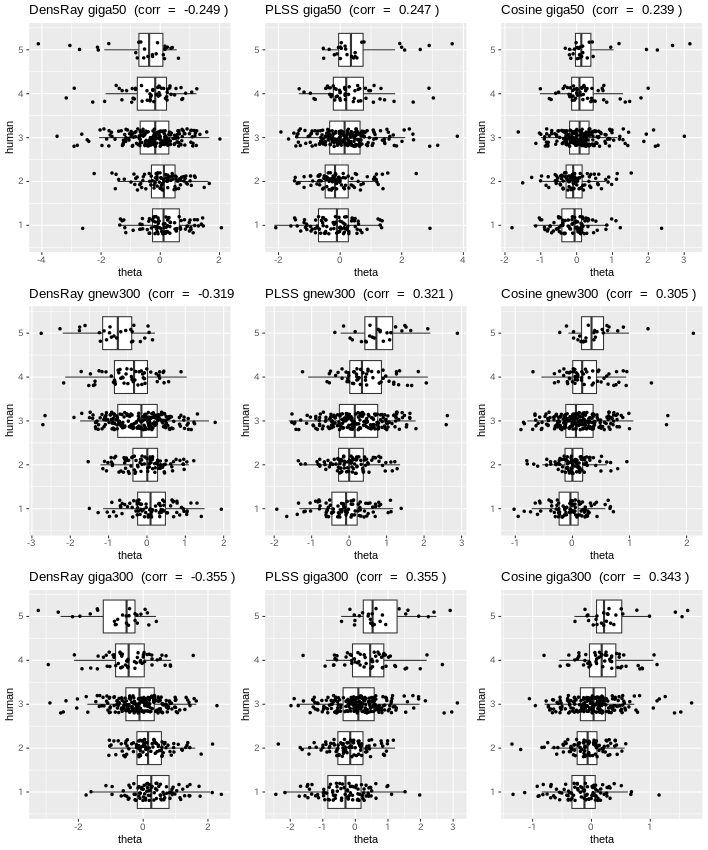

In [36]:
%%R -w 25 -h 30 --units cm
gridExtra::grid.arrange(g_dr_giga50, g_plss_giga50, g_cos_giga50, g_dr_gnews300, g_plss_gnews300, g_cos_gnews300, g_dr_giga300, g_plss_giga300, g_cos_giga300, ncol = 3);

## 未確認項目

今回は、少量の極性辞書を用いることで、単語極性の意味方向 $\boldsymbol{\beta}$ を設計したが、こうした辞書が分析対象について自明に作成できるとはかぎらない。  
PLSS では、そうした場合でも典型的な「正例」テキストと「負例」テキストは示せることが多いとして、それらを用いて $\boldsymbol{\beta}$ を推定する方法を提案している。  
 
テキストの連続的な尺度を推定できるようになったとして、分析対象のテキストをどうやって抽出するかという問題が残る。  
PLSS では、背景分布を持つ LDA とニューラル文書ベクトルを用いて、各テキストが分析したいキーワード集合に関係する「関係確率」を求めることで分析対象のテキストを客観的に抽出する手法を提案している。